In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import TensorDataset, DataLoader

import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

data

In [2]:
data = web.DataReader('AAPL','yahoo',datetime(2018,1,1),datetime.today())

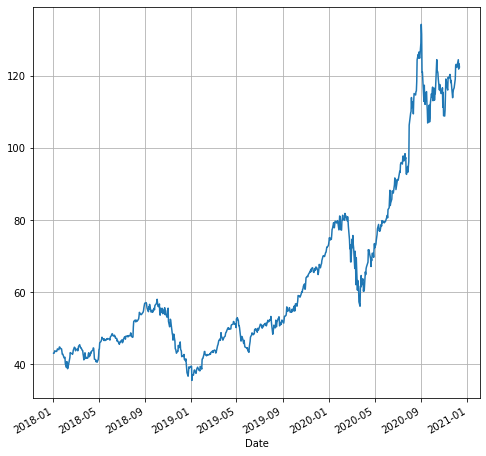

In [3]:
data['Close'].plot(figsize=(8,8),grid=True)

In [4]:
def preprocess_data(series: np.array, seq_len: int) -> np.array:
    tmp = [series[i:i+seq_len] for i in range(len(series)) if (i+seq_len) < len(series)-1]
    return np.array(tmp)

In [5]:
def preprocess_label(series: np.array, seq_len: int) -> np.array:
    tmp = [series[i+seq_len+1] for i in range(len(series)) if (i+seq_len+1) < len(series)]
    return np.array(tmp).reshape(-1,1)

In [6]:
TS = preprocess_data(data['Close'].to_numpy(),5)

In [7]:
TS_LABEL = preprocess_label(data['Close'].to_numpy(),5)

In [8]:
tsdataset = TensorDataset(torch.from_numpy(TS),torch.from_numpy(TS_LABEL))
tsloader = DataLoader(tsdataset,batch_size=32)

model

In [9]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

In [10]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

In [11]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [12]:
model = TemporalConvNet(num_inputs=1, num_channels=[1,32,64,128,1]).float()

In [13]:
#檢測輸出
with torch.no_grad():
    model.eval() # input_channel, num_input, kernel_size, 
    print(model(torch.randn(32,1,5)).shape) # batch_size, out_channel, seqence_len

torch.Size([32, 1, 5])


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

training

In [15]:
epoches = 10

In [16]:
model.train()
for e in range(epoches):
    running = 0.0
    for tss in tsloader:
        series, label = tss
        series = series.unsqueeze(1).float()
        
        output = model(series)
        output = output[:,:,-1]
        
        optimizer.zero_grad()
        loss = criterion(output, label.float())
        loss.backward()
        optimizer.step()
        running+=loss.item()
        
    print(f'epoch {e+1}: {running/len(tsdataset)}')

epoch 1: 52.746754018713695
epoch 2: 4.8323552402259535
epoch 3: 3.971016872204143
epoch 4: 3.840624483501895
epoch 5: 3.5466686094146893
epoch 6: 2.54075456021437
epoch 7: 2.30012496484992
epoch 8: 3.028981644877585
epoch 9: 5.399794649721971
epoch 10: 2.3975727309041948


evaluation

In [28]:
with torch.no_grad():
    model.eval()
    forecasting = []
    for xs,ys in tsdataset:
        output = model(xs.view(1,1,-1).float())[:,:,-1].flatten()
        forecasting.append(output.item())

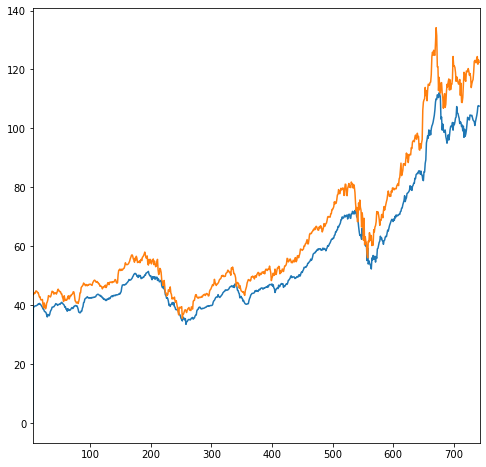

In [40]:
plt.figure(figsize=(8,8))
plt.xlim(5+1,len(data))
plt.plot(np.pad(forecasting,(5+1,0),mode='constant'))
plt.plot(data['Close'].to_numpy())

for netron

In [8]:
torch.onnx.export(model,torch.randn(1,3,10),'a.onnx')